In the past year or so, I've become a full-fledged tidy data convert. I use pandas and seaborn for almost everything that I do, and any time I figure out a new cool groupby trick I feel like I've PhD-leveled up.

That's why it's so frustrating that I still can't find a good way to plot categorical scatterplots.

I want:

* an easy way to plot a scatterplot where the points are colored according to an associated categorical variable.
* to be able to manipulate this plot on the Axes object level (so that I can place it wherever I want, and so I can modify parameters after making the plot)
* to be flexible with respect to my categorical variables (i.e. I don't want to hard-code any of them in, so that the plot is automatically updated if the number/identities of my categories change)
* the code to be elegant and in the spirit of tidy data! 

Seaborn
=======

As a tidy data convert, my first go-to is almost always seaborn. [Seaborn](http://seaborn.pydata.org/) is great and I highly encourage everyone plotting in Python to get used to it. Functions for different types of plots all take basically the same inputs, so it's trivial to change your barplot into a boxplot and so on. It's also really easy to slice and dice your data in different ways: you just tell seaborn which column is the x axis, y axis, color, etc. It's also really nice because you can usually make a nice-looking plot with one line of code! 

That said, every time I want to plot a scatterplot with points colored according to a categorical variable, I furiously google and [StackOverflow](http://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels-using-matplotlib) and end up with the following options that might be able to do what I want.

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style('white')
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


lmplot
-------

`lmplot` seems like the obvious first choice, since it makes the plot I want. `lmplot` is a wrapper around `regplot`, which makes a scatter plot of x vs y-variables, and fits a regression to the relatinoship. When you turn off the regression, it's just a scatterplot. `lmlplot` wraps this functionality into a `FacetGrid` so that you can split your data according to a `hue` variable (and do the regression on each category separately).

However, it makes and returns a new `FacetGrid` instance, and it's unclear to me how to interact with the underlying `Axes` object. Also, there isn't any way to pass an existing `Axes` instance to the function, and so I can't put this plot on an existing figure (e.g. that I made using `plt.subplots()` or with GridSpec). I'm forced to have this be its own new stand-alone figure.

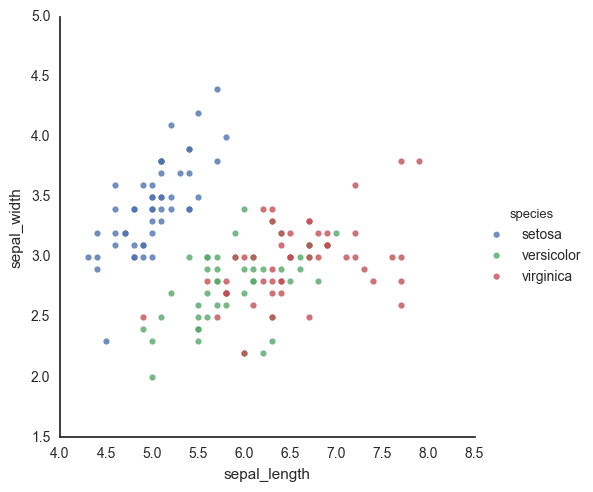

In [6]:
sns.lmplot(data=df, x='sepal_length', y='sepal_width', hue='species', fit_reg=False)

TypeError: lmplot() got an unexpected keyword argument 'ax'

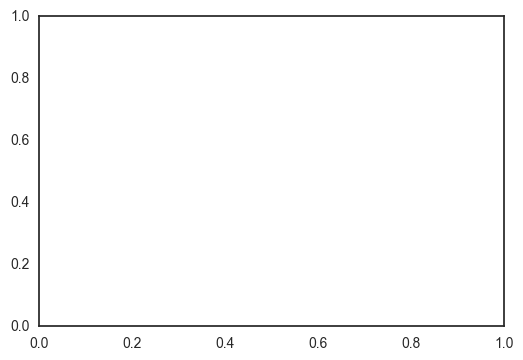

In [7]:
fig, ax = plt.subplots()
sns.lmplot(data=df, x='sepal_length', y='sepal_width', hue='species', fit_reg=False, ax=ax)

pointplot
---------

This is another option I always forget about until I'm well into the rabbit hole (surprisingly, it doesn't come up often in my google searches). That said, maybe the reason it doesn't come up is that it actually doesn't do what I want. I'm not sure how to use this function to plot the individual points. This plotting function aggregates the points in each category with an estimator, and the [documentation](http://seaborn.pydata.org/generated/seaborn.pointplot.html) even makes this explicit:

> It is important to keep in mind that a point plot shows only the mean (or other estimator) value

There go all my hopes and dreams...

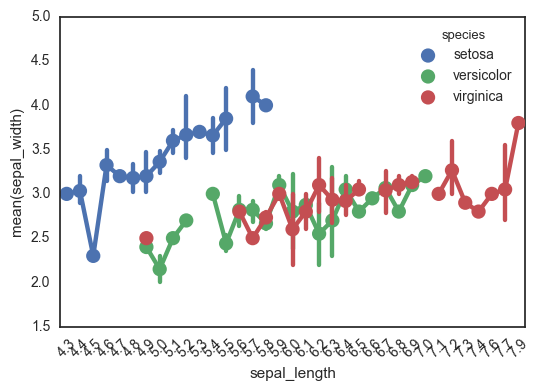

In [8]:
ax = sns.pointplot(data=df, x='sepal_length', y='sepal_width', hue='species')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig.tight_layout()

Another really important caveat with this function is that it treats the x-axis as *categorical* values - I've been tripped up by this before! This can really mess up your interpretation of the graph, if you're expecting to look for a relationship between continuous x and y-values. This is *definitely* not the right kind of plot for this.

In the following plot, for example, look at how the x-axis jumps from 0.6 to 1.0. Ruh roh!

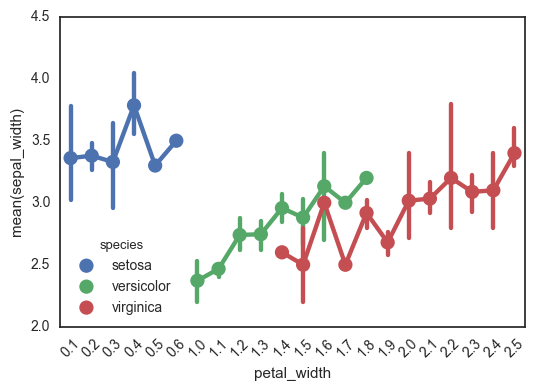

In [9]:
ax = sns.pointplot(data=df, x='petal_width', y='sepal_width', hue='species')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig.tight_layout()

FacetGrid
---------

Finally, we can go old-school `FacetGrid` + `plt.scatter` (I don't know why this registers are "old-school" in my mind but it does). Again, however, this returns a FacetGrid that you can't easily manipulate or move around. Womp womp.

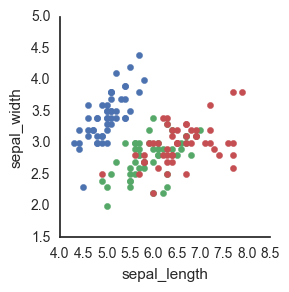

In [10]:
g = sns.FacetGrid(data=df, hue='species')
g.map(plt.scatter, 'sepal_length', 'sepal_width')

Because seaborn is a statistical plotting package, it tends to focus on making doing fancy things easier (while often times making doing easy things fancier...) This is one of those instances where it's not totally clear to me how to just plot the raw data.

ggplot
======

Okay fine maybe seaborn is too fancy to actually do this simple thing. Obviously what I want is to recapitulate R's ggplot functionality so why not use Python's own ggplot?

Answer: honestly, because it's a bit too early in its development and I find the lack of documentation frustrating. For example, I can't seem to find whether you pass in an Axis instance to the ggplot call somewhere to specify where to make the plot.

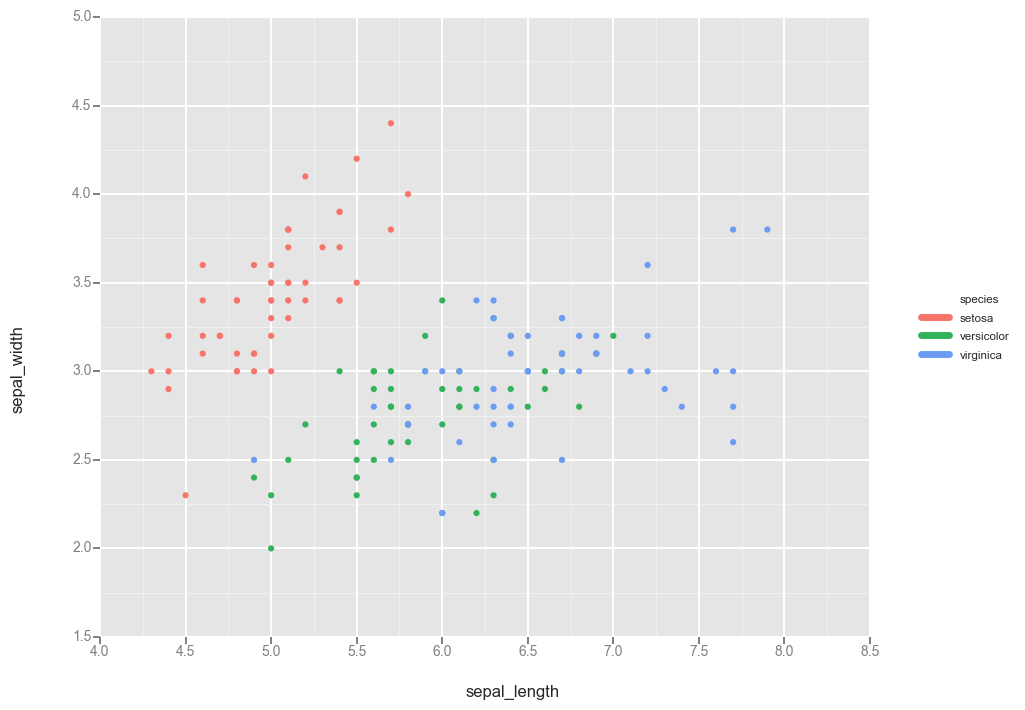

<ggplot: (294909377)>

In [11]:
import ggplot as gg
gg.ggplot(df, gg.aes(x='sepal_length', y='sepal_width', color='species')) + gg.geom_point()


I also found that ggplot does a terrible job of dealing with nan's in the categorical value, considering them each an individual category. I imagine this has to do with the behavior of `set`, which also does not collapse nan's together.

In [12]:
import numpy as np

dfnan = df.append(pd.DataFrame(data=np.random.uniform(size=(4,5), low=4, high=8), columns=df.columns), ignore_index=True)
dfnan.loc[df.shape[0]:, 'species'] = np.nan
dfnan.tail(10)

,sepal_length,sepal_width,petal_length,petal_width,species
144,6.700000,3.300000,5.700000,2.500000,virginica
145,6.700000,3.000000,5.200000,2.300000,virginica
146,6.300000,2.500000,5.000000,1.900000,virginica
147,6.500000,3.000000,5.200000,2.000000,virginica
148,6.200000,3.400000,5.400000,2.300000,virginica
149,5.900000,3.000000,5.100000,1.800000,virginica
150,7.074309,7.972696,7.909355,4.219897,NaN
151,4.458424,4.172552,6.849114,7.951780,NaN
152,4.502440,5.012546,7.600676,4.141593,NaN
153,4.138379,5.966933,7.956917,7.337878,NaN


KeyError: nan

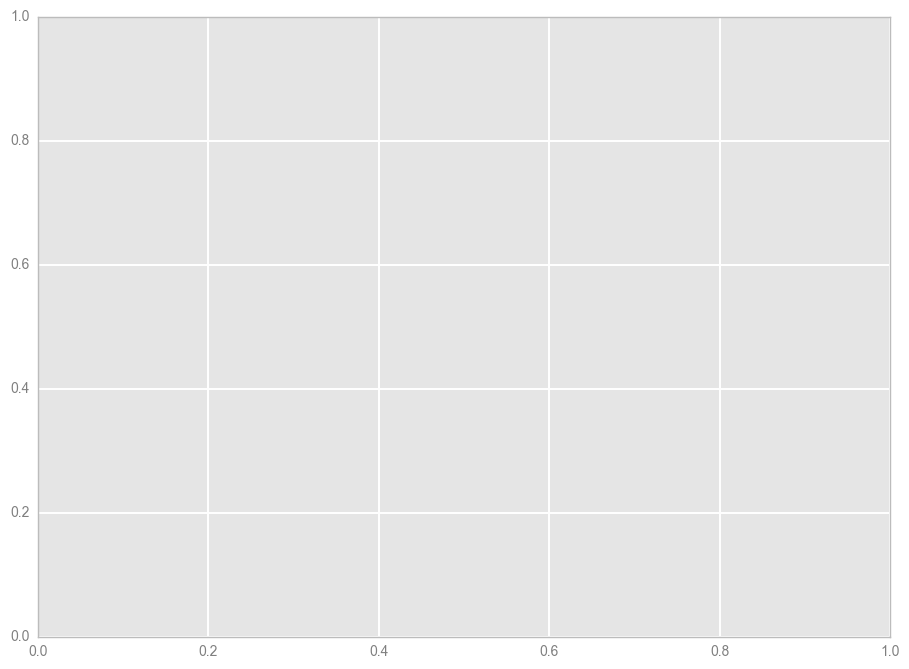

In [13]:
gg.ggplot(dfnan, gg.aes(x='sepal_length', y='sepal_width', color='species')) + gg.geom_point()


I could probably dig into this more, but honestly I don't really want to go down this rabbit hole. I'm just not hardcore enough to debug something that I know is still very early in development, and there isn't enough documentation or StackOverflow posts about it to be worth the investment.

pandas
------

I could probably use pandas, but as this [fun article](https://dansaber.wordpress.com/2016/10/02/a-dramatic-tour-through-pythons-data-visualization-landscape-including-ggplot-and-altair/) points out, I haven't really found any cases where plotting with pandas is particularly more elegant than just going straight to matplotlib.

matplotlib
----------

So the first option with matplotlib is to manually define a dictionary mapping each categorical value to a color, as in this [StackOverflow response](http://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels-using-matplotlib).

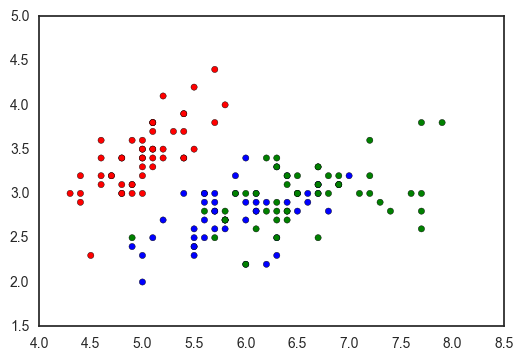

In [17]:
df = sns.load_dataset('iris')
fig, ax = plt.subplots()
colors = {'setosa': 'red', 'versicolor': 'blue', 'virginica': 'green'}
ax.scatter(df['sepal_length'], df['sepal_width'], c=df['species'].apply(lambda x: colors[x]))


However, this has a few downsides:

- you have to manually set the color for each variable
- it breaks if there are values in your column which are not in the color mapping dict
- and it doesn't seem to work with nan's
- it's pretty ugly

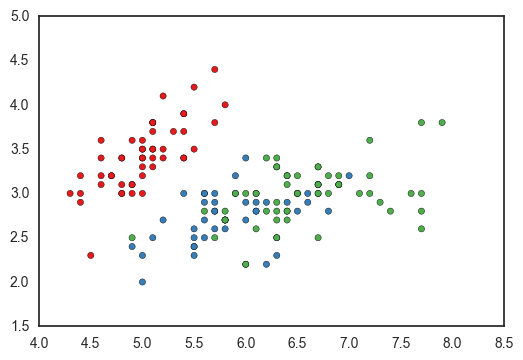

In [18]:
colors = {i: j for i, j in zip(df['species'].unique(), sns.color_palette('Set1', len(df['species'].unique())))}
fig, ax = plt.subplots()
ax.scatter(df['sepal_length'], df['sepal_width'], c=df['species'].apply(lambda x: colors[x]))


You could programmatically define the dictionary, but you'll have to handle `nan`s manually. Using `nan` as a dictionary key returns a `KeyError` because `nan` isn't equal to itself (more [here](http://stackoverflow.com/questions/6441857/nans-as-key-in-dictionaries)).

KeyError: nan

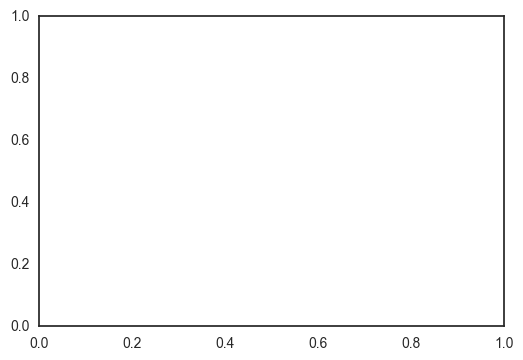

In [19]:
colors = {i: j for i, j in zip(dfnan['species'].unique(), sns.color_palette('Set1', len(dfnan['species'].unique())))}
fig, ax = plt.subplots()
ax.scatter(dfnan['sepal_length'], dfnan['sepal_width'], c=dfnan['species'].apply(lambda x: colors[x]))

In my case, I ended up going with the ugly, manual, versatile matplotlib way to make my plot: replacing `nan`'s with strings, manually defining my dictionary, adding a column with the colors, and using groupby to plot - but only because I knew exactly what values I was expecting. 

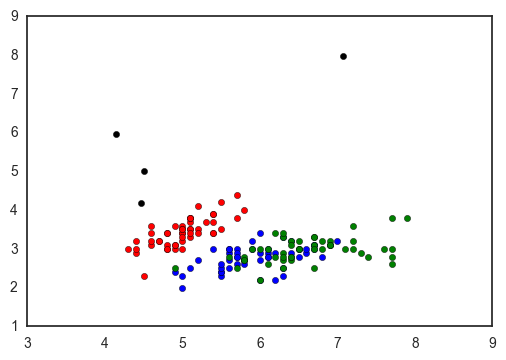

In [20]:
fig, ax = plt.subplots()
colors = {'setosa': 'red', 'versicolor': 'blue', 'virginica': 'green', 'nan': 'black'}
dfnan = dfnan.replace(np.nan, 'nan')
for c, subdf in dfnan.groupby('species'):
    ax.scatter(subdf['sepal_length'], subdf['sepal_width'], c=colors[c], label=c)


I feel like the scatterplot is one of the breads and butters of data visualization - and though I recognize why seaborn approaches it the way it does, I'm still so surprised that there's no easy and versatile way to make a scatterplot colored by a categorical varaiable! 

What do you use to make this common plot? Am I missing something obvious??!